# Trying to Predict the class of image of blood cells

In [12]:
#importing matrix library
import numpy as np
#import tabular library
import pandas as pd
#visualization library
import matplotlib.pyplot as plt
import seaborn as sns
#Tensorflow neural network
import tensorflow as tf
#result
from sklearn.metrics import accuracy_score,classification_report
import plotly.express as px

# Loading the Images

In [2]:
train_dir="/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_dir="/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST"

In [3]:
#creating generators
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
#creating generators
test_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

In [4]:
#Flowing image data
train_images=train_gen.flow_from_directory(
directory=train_dir,
target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')
val_images=train_gen.flow_from_directory(
directory=train_dir,
target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')
test_images=train_gen.flow_from_directory(
directory=test_dir,
target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='training')

Found 7968 images belonging to 4 classes.
Found 7968 images belonging to 4 classes.
Found 1991 images belonging to 4 classes.


# Build Pretrained Model

In [5]:
pretrained_model=tf.keras.applications.MobileNetV2(
input_shape=(224,224,3),include_top=False,weights='imagenet',
pooling='avg')
pretrained_model.trainable=False

2023-02-13 03:58:55.615666: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


# Building Classification Model

In [6]:
inputs=pretrained_model.input
x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
outputs=tf.keras.layers.Dense(4,activation='softmax')(x)
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
)


In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training the Model

In [9]:
history=model.fit(train_images,
                 validation_data=val_images,
                 epochs=2,
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(
                     monitor='val_loss',
                     patience=3,
                     restore_best_weights=True)
                 ])

Epoch 1/2
249/249 [==============================] - 185s 744ms/step - loss: 1.9829e-04 - accuracy: 1.0000 - val_loss: 1.9026e-04 - val_accuracy: 1.0000
Epoch 2/2
249/249 [==============================] - 185s 743ms/step - loss: 1.7695e-04 - accuracy: 1.0000 - val_loss: 1.4930e-04 - val_accuracy: 1.0000


In [13]:
fig=px.line(
history.history,
y=['loss','val_loss'],
labels={'index':'Epochs','value':'Loss'},
title='Training and Validation Loss Over time')
fig.show()

# Results

In [14]:
CLASS_NAMES=list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Test Accuracy:52.737%


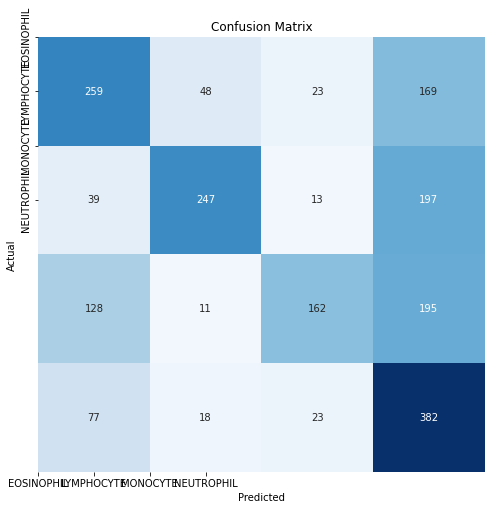

Classification Report:
-----------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.51      0.52      0.52       499
  LYMPHOCYTE       0.76      0.50      0.60       496
    MONOCYTE       0.73      0.33      0.45       496
  NEUTROPHIL       0.41      0.76      0.53       500

    accuracy                           0.53      1991
   macro avg       0.60      0.53      0.53      1991
weighted avg       0.60      0.53      0.53      1991



In [17]:
predictions=np.argmax(model.predict(test_images),axis=1)
acc=accuracy_score(test_images.labels,predictions)
cm=tf.math.confusion_matrix(test_images.labels,predictions)
clr=classification_report(test_images.labels,predictions,target_names=CLASS_NAMES)
print('Test Accuracy:{:.3f}%'.format(acc*100))
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(4)*0.5,labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4)*0.5,labels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('Classification Report:\n-----------------\n',clr)
